# Import

In [1]:
import geopandas as gpd
# gpd.options.display_precision = 7
from geopandas import GeoDataFrame
from geopandas.tools import sjoin
from shapely.geometry import Point

import pandas as pd
# pd.options.display.max_columns=100
# pd.options.display.max_rows=100
import math

import zipfile
import requests
import io

import matplotlib.pyplot as plt
import matplotlib.cm as cmap
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

# Open GeoPackage files

In [2]:
# census data from Lisbon-PT
url = 'https://mapas.ine.pt/download/filesGPG/2021/municipios/BGRI2021_1106.zip'
filename = 'BGRI2021_1106.gpkg'

r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extract(filename)

# openlisbon shape
lisbon = gpd.read_file(filename)
print('size of the df: ', lisbon.shape)
lisbon.iloc[[0,1,2], [0,1,-1]]

size of the df:  (2822, 48)


,OBJECTID,BGRI2021,geometry
0,30243,11065602301,"MULTIPOLYGON (((-86809.545 -103264.238, -86801..."
1,30244,11065700203,"MULTIPOLYGON (((-88183.921 -103236.850, -88218..."
2,30311,11065801011,"MULTIPOLYGON (((-94424.359 -107038.246, -94495..."


Geopackage files typically contain a column named “geometry,” recognized by GeoPandas as representing the shape of areas or points.

In [3]:
lisbon.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2822 entries, 0 to 2821
Data columns (total 48 columns):
 #   Column                                                         Non-Null Count  Dtype   
---  ------                                                         --------------  -----   
 0   OBJECTID                                                       2822 non-null   int64   
 1   BGRI2021                                                       2822 non-null   object  
 2   DT21                                                           2822 non-null   object  
 3   DTMN21                                                         2822 non-null   object  
 4   DTMNFR21                                                       2822 non-null   object  
 5   DTMNFRSEC21                                                    2822 non-null   object  
 6   SECNUM21                                                       2822 non-null   object  
 7   SSNUM21                                    

The Census dataframe for Lisbon contains various levels of aggregation, from the most granular — “SUBSECCAO” — to the most aggregated — “DTMNFR21” of the city of Lisbon:

- DTMNFR21 — with 24 units
- DTMNFRSEC21 — with 522 units
- SUBSECCAO — with 2822 units

In [4]:
print('Number of neighborhood in Lisbon: ', len(lisbon['DTMNFR21'].unique()))
print('Number of statistical section in Lisbon: ', len(lisbon['DTMNFRSEC21'].unique()))
print('Number of statistical subsection in Lisbon: ', len(lisbon['SUBSECCAO'].unique()))

Number of neighborhood in Lisbon:  24
Number of statistical section in Lisbon:  522
Number of statistical subsection in Lisbon:  2822


# Plotting maps

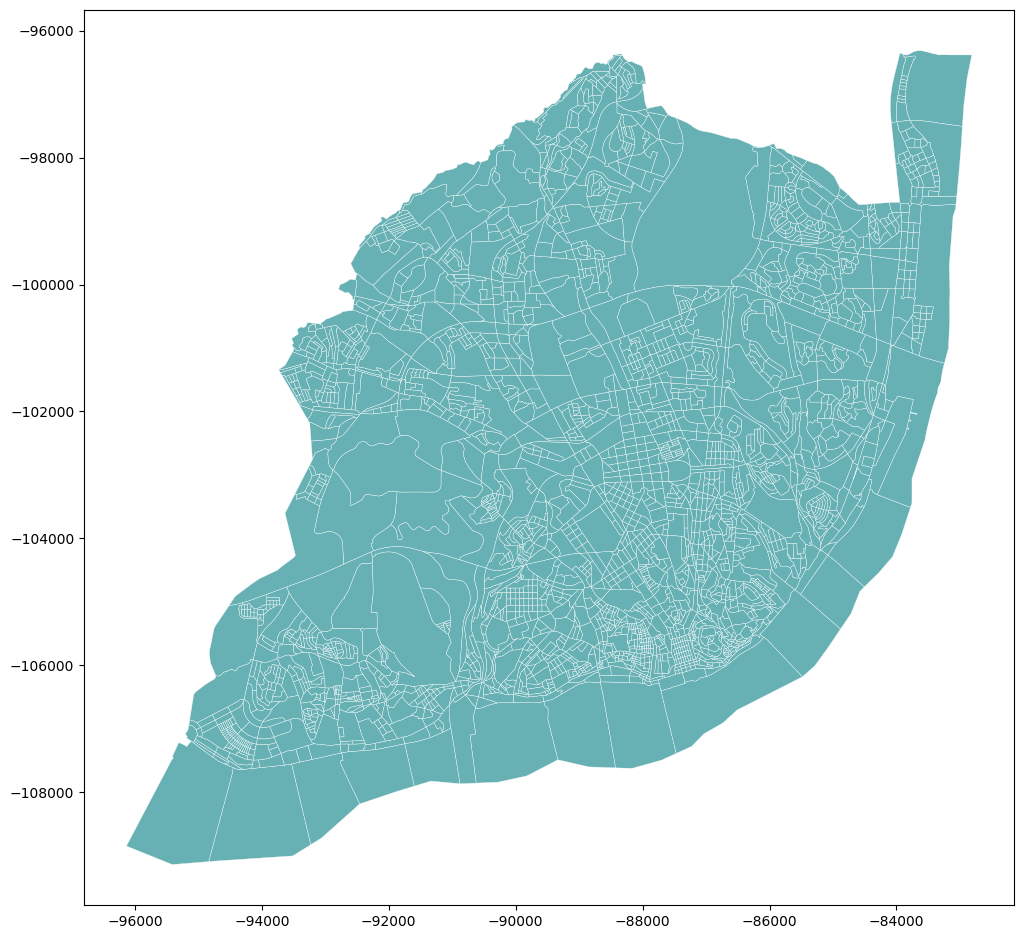

In [5]:
# First plot of the df of Lisbon

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

lisbon.plot(aspect=1,
            edgecolor="white",
            linewidth=0.25,
            color='#67B1B5',
            ax=ax);

## Aggregate areas to the statistical section

In [6]:
# select only numerical columns of census data
census_col = [x for x in lisbon.columns.to_list() if x.startswith('N_')]
print(census_col)

['N_EDIFICIOS_CLASSICOS', 'N_EDIFICIOS_CLASS_CONST_1_OU_2_ALOJ', 'N_EDIFICIOS_CLASS_CONST_3_OU_MAIS_ALOJAMENTOS', 'N_EDIFICIOS_EXCLUSIV_RESID', 'N_EDIFICIOS_1_OU_2_PISOS', 'N_EDIFICIOS_3_OU_MAIS_PISOS', 'N_EDIFICIOS_CONSTR_ANTES_1945', 'N_EDIFICIOS_CONSTR_1946_1980', 'N_EDIFICIOS_CONSTR_1981_2000', 'N_EDIFICIOS_CONSTR_2001_2010', 'N_EDIFICIOS_CONSTR_2011_2021', 'N_EDIFICIOS_COM_NECESSIDADES_REPARACAO', 'N_ALOJAMENTOS_TOTAL', 'N_ALOJAMENTOS_FAMILIARES', 'N_ALOJAMENTOS_FAM_CLASS_RHABITUAL', 'N_ALOJAMENTOS_FAM_CLASS_VAGOS_OU_RESID_SECUNDARIA', 'N_RHABITUAL_ACESSIVEL_CADEIRAS_RODAS', 'N_RHABITUAL_COM_ESTACIONAMENTO', 'N_RHABITUAL_PROP_OCUP', 'N_RHABITUAL_ARRENDADOS', 'N_AGREGADOS_DOMESTICOS_PRIVADOS', 'N_ADP_1_OU_2_PESSOAS', 'N_ADP_3_OU_MAIS_PESSOAS', 'N_NUCLEOS_FAMILIARES', 'N_NUCLEOS_FAMILIARES_COM_FILHOS_TENDO_O_MAIS_NOVO_MENOS_DE_25', 'N_INDIVIDUOS', 'N_INDIVIDUOS_H', 'N_INDIVIDUOS_M', 'N_INDIVIDUOS_0_14', 'N_INDIVIDUOS_15_24', 'N_INDIVIDUOS_25_64', 'N_INDIVIDUOS_65_OU_MAIS']


In [7]:
# union on statistical section
lisbon_statistical_section = lisbon[census_col + ['DTMNFRSEC21', 'geometry']].dissolve(by='DTMNFRSEC21', aggfunc='sum').reset_index()
print('shape of lisbon_statistical_section: ', lisbon_statistical_section.shape)

# union on neighborhood
lisbon_neighborhood = lisbon[census_col + ['DTMNFR21', 'geometry']].dissolve(by='DTMNFR21', aggfunc='sum').reset_index()
print('shape of lisbon_neighborhood: ', lisbon_neighborhood.shape)

shape of lisbon_statistical_section:  (522, 34)
shape of lisbon_neighborhood:  (24, 34)


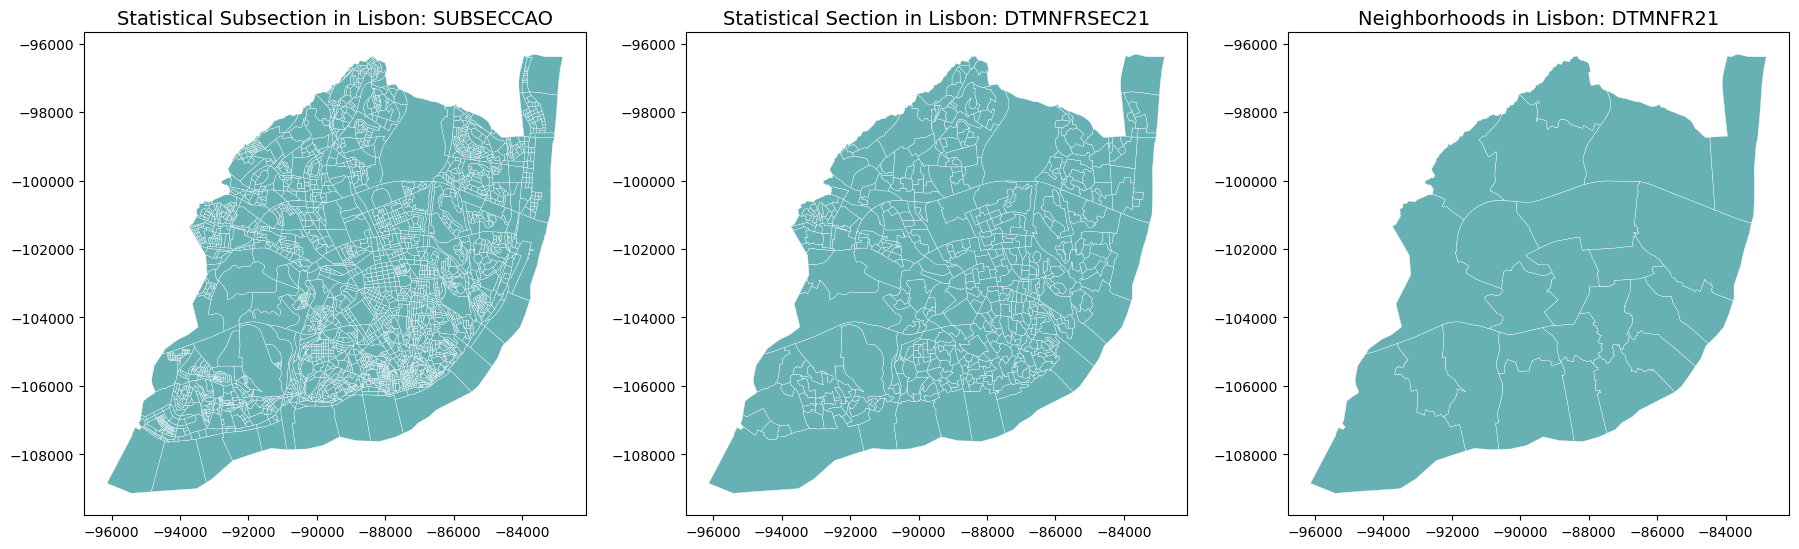

In [8]:
# Plot the aggregated areas

fig, ax = plt.subplots(1, 3, figsize=(22, 12))

lisbon.plot(aspect=1,
            edgecolor="white",
            linewidth=0.25,
            color='#67B1B5',
            ax=ax[0])

ax[0].set_title('Statistical Subsection in Lisbon: SUBSECCAO', fontsize=14)

lisbon_statistical_section.plot(aspect=1,
                                edgecolor="white",
                                linewidth=0.25,
                                color='#67B1B5',
                                ax=ax[1])

ax[1].set_title('Statistical Section in Lisbon: DTMNFRSEC21', fontsize=14)

lisbon_neighborhood.plot(aspect=1,
                         edgecolor="white",
                         linewidth=0.25,
                         color='#67B1B5',
                         ax=ax[2])

ax[2].set_title('Neighborhoods in Lisbon: DTMNFR21', fontsize=14);

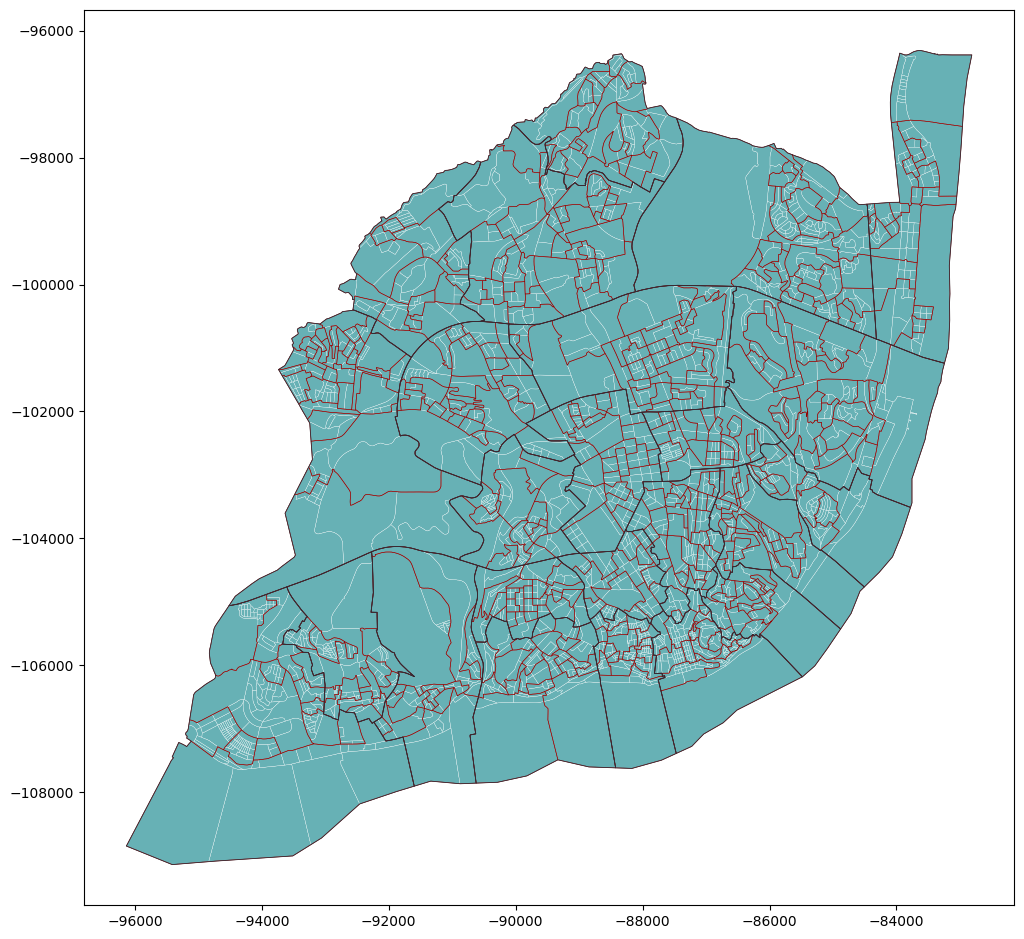

In [9]:
# Plot all aggregations in the same map

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

lisbon.plot(aspect=1,
            edgecolor="white",
            linewidth=0.2,
            color='#67B1B5',
            ax=ax)

lisbon_statistical_section.plot(aspect=1,
                                edgecolor="darkred",
                                linewidth=0.4,
                                facecolor="none",
                                ax=ax)


lisbon_neighborhood.plot(aspect=1,
                         edgecolor="#372932",
                         linewidth=0.6,
                         facecolor="none",
                         ax=ax);

## Plot maps with a column value

In [10]:
# Calculate the total number of buildings in each statistical section
lisbon_statistical_section['N_EDIFICIOS'] = lisbon_statistical_section['N_EDIFICIOS_1_OU_2_PISOS'] + lisbon_statistical_section['N_EDIFICIOS_3_OU_MAIS_PISOS']

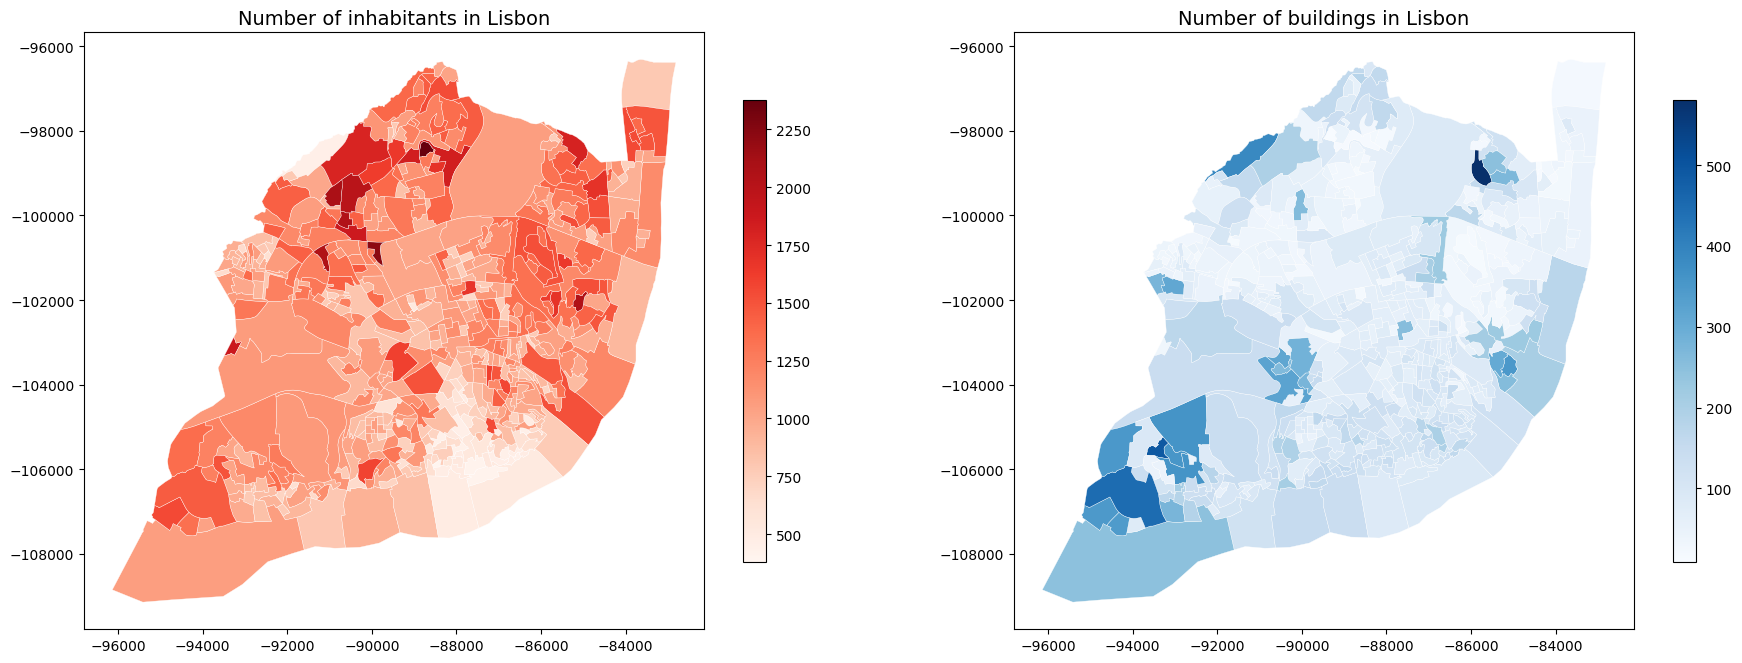

In [11]:
# plot the maps with the legend as the columns values

fig, ax = plt.subplots(1, 2, figsize=(22, 12))

lisbon_statistical_section.plot(aspect=1,
                                column='N_INDIVIDUOS',
                                edgecolor="white",
                                linewidth=0.25,
                                cmap='Reds',
                                legend_kwds={'shrink': 0.5},
                                legend=True,
                                ax=ax[0])
ax[0].set_title('Number of inhabitants in Lisbon', fontsize=14)

lisbon_statistical_section.plot(aspect=1,
                                column='N_EDIFICIOS',
                                edgecolor="white",
                                linewidth=0.25,
                                cmap='Blues',
                                legend_kwds={'shrink': 0.5},
                                legend=True,
                                ax=ax[1])
ax[1].set_title('Number of buildings in Lisbon', fontsize=14);

# Calculating geometric features

## Area

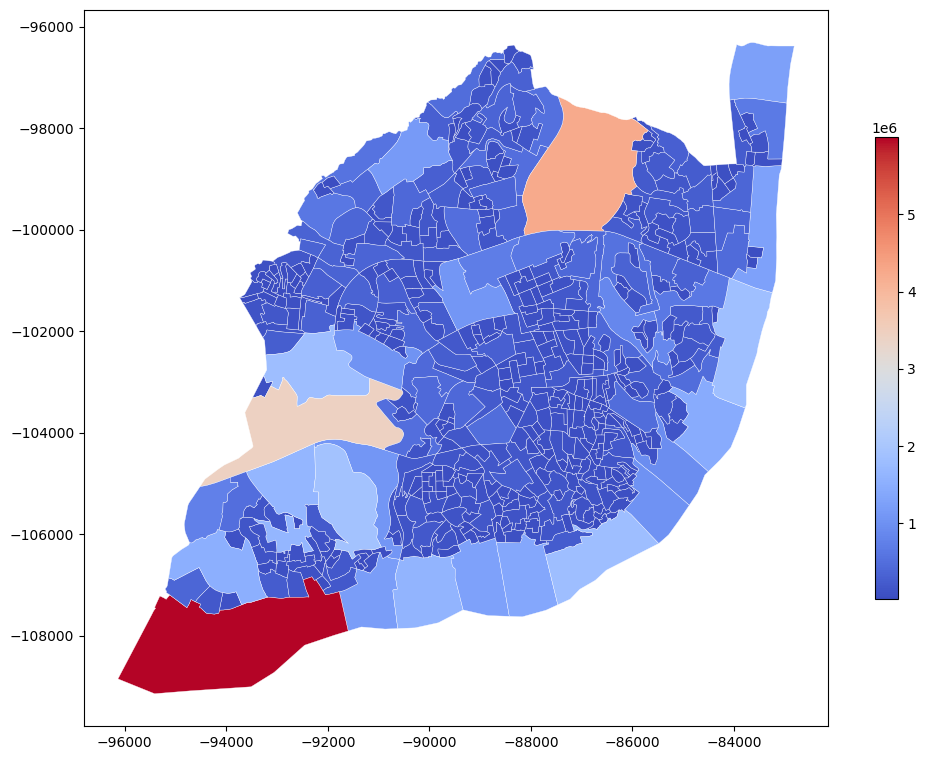

In [12]:
# geometric features need to be calculated before crs transformation
lisbon_statistical_section['area'] = lisbon_statistical_section['geometry'].area

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

lisbon_statistical_section.plot(aspect=1,
                                column='area',
                                edgecolor="white",
                                linewidth=0.25,
                                cmap='coolwarm',
                                legend_kwds={'shrink': 0.5},
                                legend=True,
                                ax=ax);

## Centroid

In [13]:
# separate a df with only the statistical section id and centroid. The geodataframe does not support two geometries
lisbon_centroid = lisbon_statistical_section[['DTMNFRSEC21', 'geometry']]
lisbon_centroid['centroid'] = lisbon_centroid['geometry'].centroid

#drop geometry
lisbon_centroid.drop(['geometry'], axis=1, inplace=True)

# rename the centroid column as geometry, this column will be used on plots
lisbon_centroid.rename(columns={'centroid': 'geometry'}, inplace=True)

lisbon_centroid.head()

,DTMNFRSEC21,geometry
0,110601001,POINT (-92368.797 -106752.175)
1,110601002,POINT (-92882.440 -106654.113)
2,110601003,POINT (-92606.608 -106377.324)
3,110601004,POINT (-92596.648 -105768.323)
4,110601005,POINT (-93389.042 -105532.664)


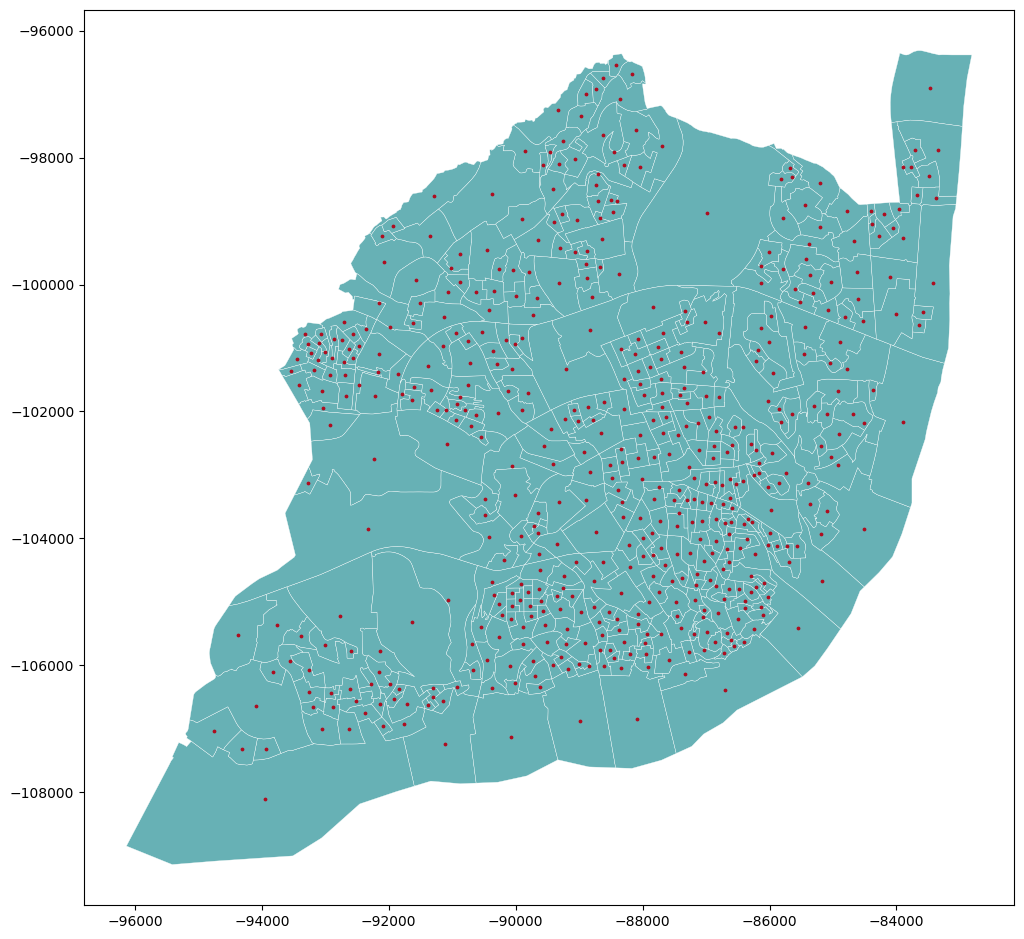

In [14]:
# Plot the centroids of the statistical sections

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

lisbon_statistical_section.plot(aspect=1,
                                edgecolor="white",
                                linewidth=0.25,
                                color='#67B1B5',
                                ax=ax)

lisbon_centroid.plot(aspect=1,
                     color='#AD0E20',
                     markersize=3,
                     ax=ax);

# Discover and transform CRS from map

The scale of the x and y axes of the plots does not reflect latitude and longitude references. To address this, we employ Coordinate Reference Systems (CRS), allowing us to locate points on Earth accurately.

To find the appropriate CRS code that represents a specific location, for example, Lisbon, we can use https://epsg.io (Portugal — EPSG:3763).

In [15]:
# identify crs reference for this file
lisbon_statistical_section.crs

<Projected CRS: EPSG:3763>
Name: ETRS89 / Portugal TM06
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Portugal - mainland - onshore.
- bounds: (-9.56, 36.95, -6.19, 42.16)
Coordinate Operation:
- name: Portugual TM06
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [16]:
# convert to WGS84 (latitude and longitude as known for global)
# https://epsg.io
lisbon_statistical_section_4326 = lisbon_statistical_section.to_crs(epsg=4326)
lisbon_statistical_section_4326.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
# convert also the df of the centroids
lisbon_centroid_4326 = lisbon_centroid.to_crs(epsg=4326)
lisbon_centroid_4326.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

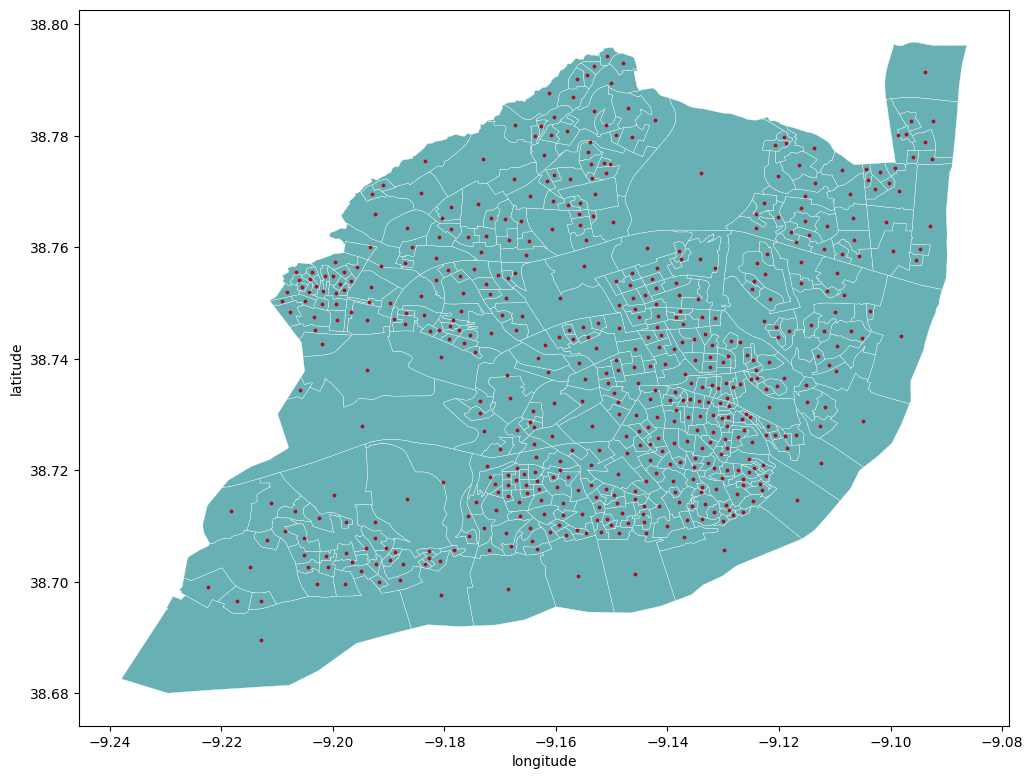

In [18]:
# Plot the map to see the difference
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

lisbon_statistical_section_4326.plot(aspect=1,
                                     edgecolor="white",
                                     linewidth=0.25,
                                     color='#67B1B5',
                                     ax=ax)

lisbon_centroid_4326.plot(aspect=1,
                          color='#AD0E20',
                          markersize=3,
                          ax=ax)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude');

# Allocating Points to Polygons
A common geospatial data task is assigning a coordinate point to a polygon. There are different approaches to this, such as:

- Allocating the point to the corresponding polygon
- Allocating the point to the polygon with the closest centroid

In [19]:
# create random points
dict_points = {'id_point': ['001', '002', '003'],
          'latitude': [38.7168, 38.7182, 38.7202],
          'longitude': [-9.1401, -9.1382, -9.1362]
        }

#allocate the points into a pandas df
points = pd.DataFrame(dict_points)

# transform this pandas df to geopandas with geometry
# create a columns with point geometry
geometry = [Point(xy) for xy in zip(points['longitude'], points['latitude'])]

points_geo = GeoDataFrame(points, crs="EPSG:4326", geometry=geometry)

points_geo

,id_point,latitude,longitude,geometry
0,001,38.7168,-9.1401,POINT (-9.14010 38.71680)
1,002,38.7182,-9.1382,POINT (-9.13820 38.71820)
2,003,38.7202,-9.1362,POINT (-9.13620 38.72020)


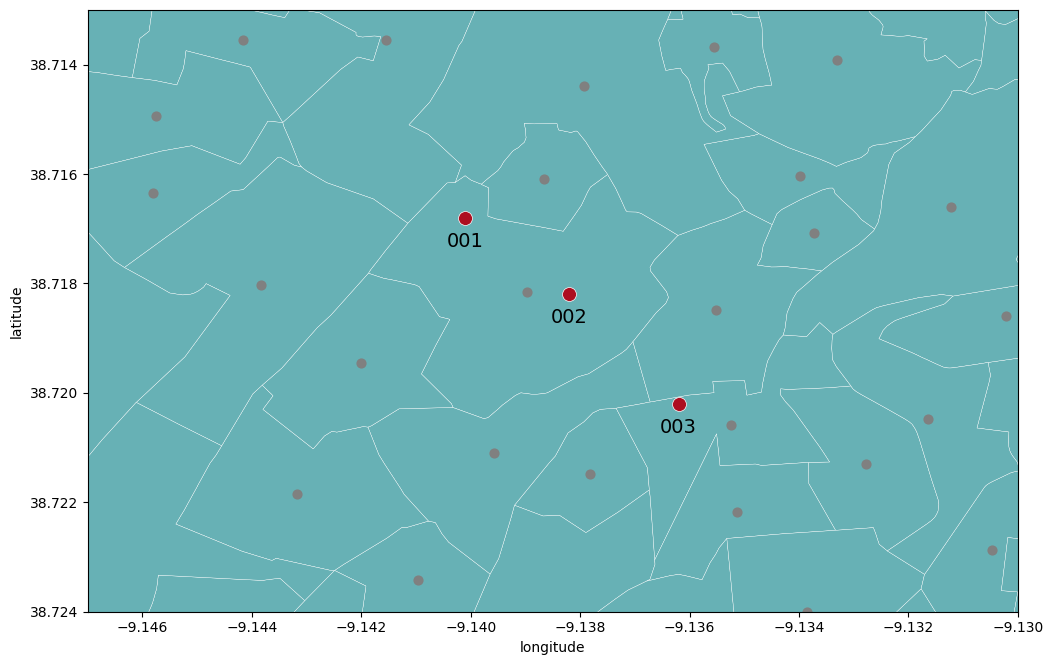

In [20]:
# Plot the created points
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

lisbon_statistical_section_4326.plot(aspect=1,
                                     edgecolor="white",
                                     linewidth=0.25,
                                     color='#67B1B5',
                                     ax=ax)

lisbon_centroid_4326.plot(aspect=1,
                          color='gray',
                          markersize=40,
                          ax=ax)

points_geo.plot(aspect=1,
                color='#AD0E20',
                markersize=100,
                linewidth=0.5,
                edgecolor="white",
                ax=ax)

for point, lat, long in zip(points_geo['id_point'], points_geo['latitude'], points_geo['longitude']):
    plt.text(long, lat+0.0006, point,
             fontsize=14, verticalalignment='bottom', horizontalalignment='center')

ax.set_xlim(-9.147,-9.13)
ax.set_ylim(38.724,38.713)

ax.set_xlabel('longitude')
ax.set_ylabel('latitude');

## Using Spatial Joins

In [21]:
# inner join to find correspondent area of a poin
join_inner_df = sjoin(lisbon_statistical_section_4326, points_geo, how="inner")

# format the df of random points to indicate the ID of the corresponding statistical section
points_geo = points_geo.merge(join_inner_df[['id_point', 'DTMNFRSEC21']], how='left', on='id_point')

points_geo

,id_point,latitude,longitude,geometry,DTMNFRSEC21
0,001,38.7168,-9.1401,POINT (-9.14010 38.71680),110656001
1,002,38.7182,-9.1382,POINT (-9.13820 38.71820),110656001
2,003,38.7202,-9.1362,POINT (-9.13620 38.72020),110656012


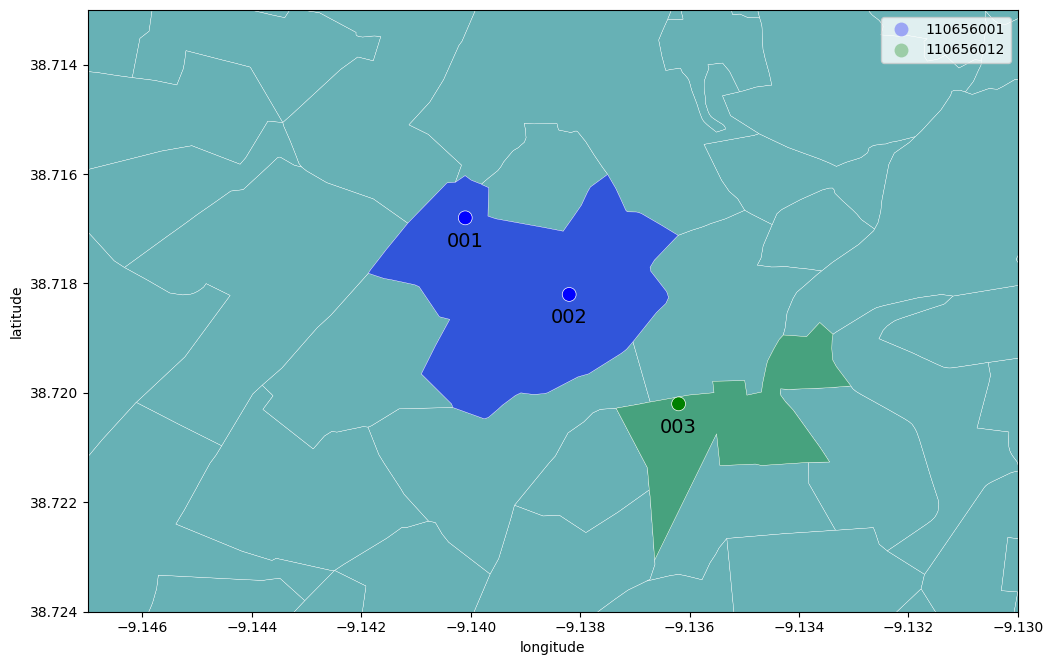

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

lisbon_statistical_section_4326.plot(aspect=1,
                                edgecolor="white",
                                linewidth=0.25,
                                color='#67B1B5',
                                ax=ax)
colors = {'110656006':'blue', '110656001':'red', '110656012':'green'}
join_inner_df.loc[lisbon_statistical_section_4326['DTMNFRSEC21'].isin(points_geo['DTMNFRSEC21'].tolist())].plot(aspect=1,
                                                                                                           column='DTMNFRSEC21',
                                                                                                           edgecolor="white",
                                                                                                           linewidth=0.25,
                                                                                                           cmap=ListedColormap(list(colors.values())),
                                                                                                           alpha=0.3,
                                                                                                           ax=ax,
                                                                                                           legend=True)

points_geo.plot(aspect=1,
                column='DTMNFRSEC21',
                cmap=ListedColormap(list(colors.values())),
                markersize=100,
                linewidth=0.5,
                edgecolor="white",
                ax=ax)

for point, lat, long in zip(points_geo['id_point'], points_geo['latitude'], points_geo['longitude']):
    plt.text(long, lat+0.0006, point,
             fontsize=14, verticalalignment='bottom', horizontalalignment='center')

ax.set_xlim(-9.147,-9.13)
ax.set_ylim(38.724,38.713)

ax.set_xlabel('longitude')
ax.set_ylabel('latitude');

## Loop to find closest centroid

In [23]:
# create separate columns with latitude and longitude from centroids
lisbon_centroid_4326['centroid_latitude'] = lisbon_centroid_4326['geometry'].y
lisbon_centroid_4326['centroid_longitude'] = lisbon_centroid_4326['geometry'].x

lisbon_centroid_4326.head(3)

,DTMNFRSEC21,geometry,centroid_latitude,centroid_longitude
0,110601001,POINT (-9.19494 38.70187),38.701871,-9.194943
1,110601002,POINT (-9.20086 38.70270),38.702700,-9.200859
2,110601003,POINT (-9.19773 38.70522),38.705222,-9.197726


In [24]:
# loop to find closest DTMNFRSEC21 using centroid

# create a tuple of (lat, long)
lisbon_centroid_4326['centroid'] = list(zip(lisbon_centroid_4326['centroid_latitude'].round(4), lisbon_centroid_4326['centroid_longitude'].round(4)))
points_geo['point'] = list(zip(points_geo['latitude'].round(4), points_geo['longitude'].round(4)))

# create a dict with DTMNFRSEC21 and centroid
sec_centroid = dict(zip(lisbon_centroid_4326['DTMNFRSEC21'], lisbon_centroid_4326['centroid']))
point_coord = dict(zip(points_geo['id_point'], points_geo['point']))

# empty dict to save information
closest_id = dict()

for id_point, point in point_coord.items():
    distance = dict()
    for sec, centroid in sec_centroid.items():
        distance[f'{sec}'] = math.dist(point, centroid)
    
    # print(min(distance.values()))
    min_id = min(distance, key=distance.get)
    closest_id[f'{id_point}'] = min_id

closest_id

{'001': '110656006', '002': '110656001', '003': '110656012'}

In [25]:
points_geo['closest_sec'] = points_geo['id_point'].map(closest_id)
points_geo

,id_point,latitude,longitude,geometry,DTMNFRSEC21,point,closest_sec
0,001,38.7168,-9.1401,POINT (-9.14010 38.71680),110656001,"(38.7168, -9.1401)",110656006
1,002,38.7182,-9.1382,POINT (-9.13820 38.71820),110656001,"(38.7182, -9.1382)",110656001
2,003,38.7202,-9.1362,POINT (-9.13620 38.72020),110656012,"(38.7202, -9.1362)",110656012


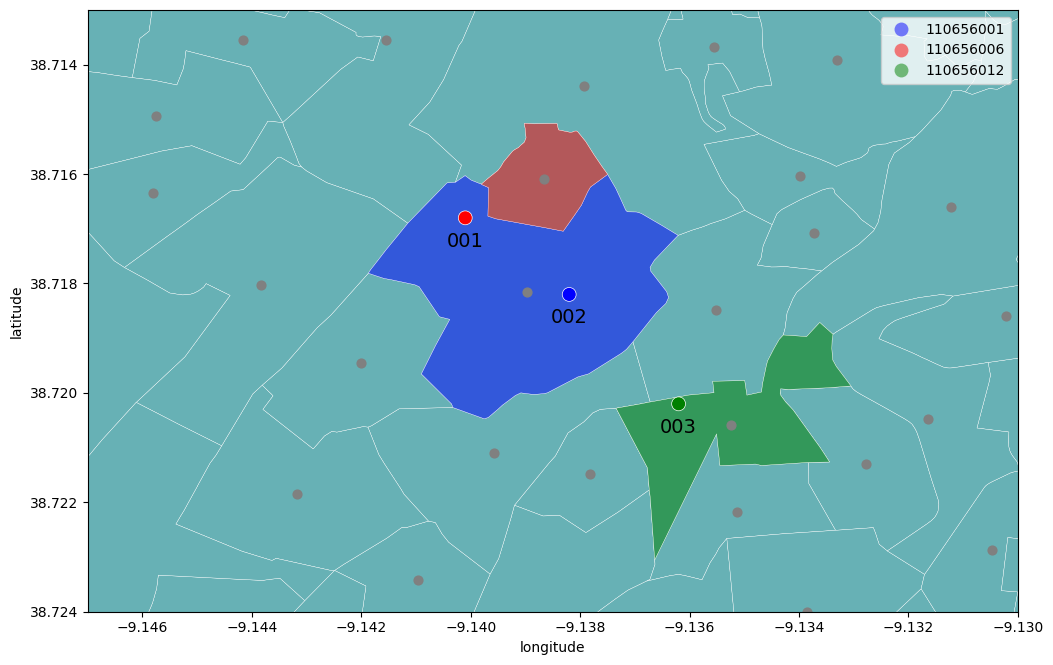

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

lisbon_statistical_section_4326.plot(aspect=1,
                                     edgecolor="white",
                                     linewidth=0.25,
                                     color='#67B1B5',
                                     ax=ax)
colors = {'110656006':'blue', '110656001':'red', '110656012':'green'}

(lisbon_statistical_section_4326
 .loc[lisbon_statistical_section_4326['DTMNFRSEC21']
            .isin(points_geo['closest_sec']
            .tolist())].plot(aspect=1,  
                             column='DTMNFRSEC21',
                             edgecolor="white",
                             linewidth=0.25,
                             cmap=ListedColormap(list(colors.values())),
                             alpha=0.5,
                             ax=ax,
                             legend=True
                        )
)

lisbon_centroid_4326.plot(aspect=1,
                     color='gray',
                     markersize=40,
                     ax=ax)

points_geo.plot(aspect=1,
                column='closest_sec',
                cmap=ListedColormap(list(colors.values())),
                markersize=100,
                linewidth=0.5,
                edgecolor="white",
                ax=ax)

for point, lat, long in zip(points_geo['id_point'], points_geo['latitude'], points_geo['longitude']):
    plt.text(long, lat+0.0006, point,
             fontsize=14, verticalalignment='bottom', horizontalalignment='center')

ax.set_xlim(-9.147,-9.13)
ax.set_ylim(38.724,38.713)

ax.set_xlabel('longitude')
ax.set_ylabel('latitude');

# Saving files

In [27]:
join_inner_df

,DTMNFRSEC21,geometry,N_EDIFICIOS_CLASSICOS,N_EDIFICIOS_CLASS_CONST_1_OU_2_ALOJ,N_EDIFICIOS_CLASS_CONST_3_OU_MAIS_ALOJAMENTOS,N_EDIFICIOS_EXCLUSIV_RESID,N_EDIFICIOS_1_OU_2_PISOS,N_EDIFICIOS_3_OU_MAIS_PISOS,N_EDIFICIOS_CONSTR_ANTES_1945,N_EDIFICIOS_CONSTR_1946_1980,...,N_INDIVIDUOS_0_14,N_INDIVIDUOS_15_24,N_INDIVIDUOS_25_64,N_INDIVIDUOS_65_OU_MAIS,N_EDIFICIOS,area,index_right,id_point,latitude,longitude
272,110656001,"POLYGON ((-9.13717 38.71666, -9.13720 38.71658...",118.0,27.0,91.0,92.0,18.0,100.0,76.0,31.0,...,84.0,60.0,467.0,113.0,118.0,139839.381351,0,001,38.7168,-9.1401
272,110656001,"POLYGON ((-9.13717 38.71666, -9.13720 38.71658...",118.0,27.0,91.0,92.0,18.0,100.0,76.0,31.0,...,84.0,60.0,467.0,113.0,118.0,139839.381351,1,002,38.7182,-9.1382
283,110656012,"POLYGON ((-9.13358 38.71991, -9.13346 38.71991...",96.0,25.0,70.0,73.0,30.0,66.0,77.0,15.0,...,88.0,72.0,576.0,153.0,96.0,59879.575236,2,003,38.7202,-9.1362


In [28]:
# save lisbon price file with EPSG:4326 - WGS84
join_inner_df.to_file('example_join_lisbon.gpkg', layer='lisbon', driver="GPKG")